In [28]:
#importing required packages
import pandas as pd
import lightgbm as lgb
import numpy as np
from pybaseball import statcast_pitcher, playerid_lookup
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score
from sklearn.model_selection import train_test_split

In [180]:
#for this first test of our model we will only be looking at Sean Manaea's 2018-2019 pitches
playerid_lookup('manaea')

Gathering player lookup table. This may take a moment.


,name_last,name_first,key_mlbam,key_retro,key_bbref,key_fangraphs,mlb_played_first,mlb_played_last
0,manaea,sean,640455,manas001,manaese01,15873,2016.0,2020.0


In [181]:
#gathering 2018-2019 pitches for Manaea 
data = statcast_pitcher('2018-03-15','2019-11-30',640455)

Gathering Player Data


In [182]:
data.shape

(2861, 89)

In [183]:
data.pitch_type.unique()

array(['FF', 'SL', 'CH', nan], dtype=object)

In [233]:
#only including rows where the pitch type is known
new_data = data.loc[data['pitch_type'].isnull()==False]

In [185]:
#25 rows were dropped in this transformation
new_data.shape

(2836, 89)

In [186]:
#resetting the index so we can loop through it later
new_data = new_data.reset_index(drop = True)

In [187]:
#need to convert the pitch types from str to int
for i in range(len(new_data)):
    if new_data['pitch_type'][i] == 'FF':
        new_data['pitch_type'][i] = 0
    elif new_data['pitch_type'][i] == 'SL':
        new_data['pitch_type'][i] = 1
    elif new_data['pitch_type'][i] == 'CH':
        new_data['pitch_type'][i] = 2

/Users/jeremiahwilson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/Users/jeremiahwilson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/jeremiahwilson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [188]:
#checking to see if the loop worked
new_data['pitch_type'].unique()

array([0, 1, 2], dtype=object)

In [189]:
#converting from dtype object to numeric
new_data['pitch_type'] = new_data['pitch_type'].apply(pd.to_numeric)

In [190]:
#getting the necessary columns for the model
X1 = new_data[['release_pos_x', 'release_pos_z', 'strikes','balls']]

In [191]:
#singling out the variable we want to predict
Y1 = new_data['pitch_type']

In [192]:
#splitting the data into training and testing sets
X_train,X_test,y_train,y_test=train_test_split(X1,Y1,test_size=0.3,random_state=0)

In [193]:
d_train=lgb.Dataset(X_train, label=y_train)

In [225]:
#setting up the parameters
params={}
params['num_leaves'] = 10
params['learning_rate']=0.03
params['boosting_type']='gbdt' #GradientBoostingDecisionTree
params['objective']='multiclass' #Multi-class target feature
params['metric']='multi_logloss' #metric for multi-class
params['max_depth']=5
params['num_class']=3 #no.of unique values in the target class not inclusive of the end value
params['min_data_in_leaf'] = 10
params['class_weight'] = 'balanced'

In [226]:
#training the model
clf=lgb.train(params,d_train,500)

In [227]:
#prediction on the test dataset
y_pred_1=clf.predict(X_test)

In [228]:
#printing the predictions
y_pred_1

array([[8.82385116e-01, 2.49669636e-02, 9.26479202e-02],
       [8.03931040e-01, 4.88990322e-02, 1.47169928e-01],
       [5.44508388e-01, 4.15913185e-01, 3.95784269e-02],
       ...,
       [6.37271791e-04, 4.92431703e-03, 9.94438411e-01],
       [8.32352252e-01, 1.97420402e-02, 1.47905708e-01],
       [1.15081000e-01, 2.59146757e-01, 6.25772243e-01]])

In [229]:
#argmax() method 
y_pred_1 = [np.argmax(line) for line in y_pred_1]

In [230]:
#using precision score for error metrics
precision_score(y_pred_1,y_test,average=None).mean()

0.5807729350001889

In [231]:
import seaborn as sns

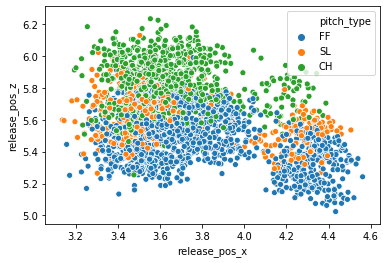

In [234]:
sns.scatterplot(new_data['release_pos_x'],new_data['release_pos_z'], hue = new_data['pitch_type'])